# Pre-computed models
This notebook generates the precomputed models provided with `dustapprox` v0.1

In [1]:
import sys
sys.path.insert(0, "../")

In [2]:
import os
import numpy as np
import pandas as pd
from glob import glob
from typing import Sequence, Union

from pyphot.astropy import UnitFilter
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from dustapprox.io import svo, ecsv
from dustapprox.tools.parallel import tqdm_joblib
from dustapprox.extinction import F99
from dustapprox.tools import grid
from dustapprox.models import polynomial, PrecomputedModel

In [3]:
%matplotlib inline
import pylab as plt

In [4]:
def compute_photometric_grid(sources: str = 'models/Kurucz2003all/*.fl.dat.txt',
                             which_filters: Sequence[Union[str, UnitFilter]] = None,
                             n_jobs: int = 1, verbose: int = 0, 
                             atmosphere_name: str = None):
    """ Run the computations of the photometric grid in parallel

    Parameters
    ----------
    sources: str
        pattern of atmospehric models to process
        (using glob syntax)
    n_jobs: int
        number of parallel processes to run (default: 1, -1 for as many as CPUs)
    verbose: int
        verbosity level (default: 0)

    Returns
    -------
    pd.DataFrame
        Dataframe with the photometric values for each passband
    """
    
    # Load relevant passbands
    if which_filters is None:
        which_filters = ['GAIA/GAIA3.G', 'GAIA/GAIA3.Gbp', 'GAIA/GAIA3.Grp',
                         'SLOAN/SDSS.u', 'SLOAN/SDSS.g', 'SLOAN/SDSS.r', 'SLOAN/SDSS.i', 'SLOAN/SDSS.z',
                         '2MASS/2MASS.J', '2MASS/2MASS.H', '2MASS/2MASS.Ks',
                         'WISE/WISE.W1', 'WISE/WISE.W2', 'WISE/WISE.W3', 'WISE/WISE.W4',
                         'GALEX/GALEX.FUV', 'GALEX/GALEX.NUV',
                         'Generic/Johnson.U', 'Generic/Johnson.B', 'Generic/Johnson.V',
                         'Generic/Cousins.R', 'Generic/Cousins.I',
                         'Generic/Bessell_JHKLM.J', 'Generic/Bessell_JHKLM.H', 'Generic/Bessell_JHKLM.K',]
    if not isinstance(which_filters[0], UnitFilter):
        passbands = svo.get_svo_passbands(which_filters)
    else:
        passbands = which_filters

    # Extinction
    extc = F99()
    Rv = np.array([3.1,])
    Av = np.sort(np.hstack([[0.01], np.arange(0.1, 20.01, 0.1)]))

    models = glob(sources)
    apfields = 'teff', 'logg', 'feh', 'alpha'
    
    with tqdm_joblib(tqdm(desc="Grid", total=len(models))):
        res = Parallel(n_jobs=n_jobs, verbose=verbose, prefer='processes')(
                delayed(grid._parallel_task)(fname, apfields, passbands, extc, Rv, Av) for fname in models
                )
    df = pd.concat(res)
    stats = df[list(apfields) + ['R0', 'A0']].agg([min, max])
    
    meta = {'extinction': {'source': extc.long_name},
            'atmosphere': {'source': atmosphere_name or sources}
           }
    
    for key in ('R0', 'A0'):
        meta['extinction'][key] = [float(stats[key]['min']), float(stats[key]['max'])]
    for key in apfields:
        meta['atmosphere'][key] = [float(stats[key]['min']), float(stats[key]['max'])]
    df.attrs.update(**meta)
    return df


def export_to_ecsv(fname: str, models: Sequence, **kwargs):
    """ Export a collection of models """
    data = pd.concat([model.to_pandas() for model in models])
    meta = models[0].to_pandas().attrs
    meta.update(**kwargs)
    ecsv.write(data.reset_index().rename(columns={'index': 'passband'}),
               fname, **meta)

In [ ]:
gaia_filters = ['GAIA/GAIA3.G', 'GAIA/GAIA3.Gbp', 'GAIA/GAIA3.Grp',]
sloan_filters = ['SLOAN/SDSS.u', 'SLOAN/SDSS.g', 'SLOAN/SDSS.r', 'SLOAN/SDSS.i', 'SLOAN/SDSS.z',]
twomass_filters = ['2MASS/2MASS.J', '2MASS/2MASS.H', '2MASS/2MASS.Ks',]
wise_filters = ['WISE/WISE.W1', 'WISE/WISE.W2', 'WISE/WISE.W3', 'WISE/WISE.W4',]
galex_filters = ['GALEX/GALEX.FUV', 'GALEX/GALEX.NUV',]
generic_filters = ['Generic/Johnson.U', 'Generic/Johnson.B', 'Generic/Johnson.V',
                   'Generic/Cousins.R', 'Generic/Cousins.I',
                   'Generic/Bessell_JHKLM.J', 'Generic/Bessell_JHKLM.H', 'Generic/Bessell_JHKLM.K',]

#features = 'teff logg feh A0 alpha'.split()
features = 'teff A0 '.split()

for pbset in (gaia_filters, sloan_filters, twomass_filters, wise_filters, galex_filters, generic_filters):
    name = pbset[0].split('/')[0].lower()
    print(name)
    print(pbset)
    grid_fname = f'precomputed/grids/kurucz_{name}_f99_a0_grid.csv'
    if not os.path.exists(grid_fname):
        r = compute_photometric_grid('../models/Kurucz2003all/*.fl.dat.txt', pbset, 
                                     n_jobs=-1, atmosphere_name='Kurucz (ODFNEW/NOVER 2003)')
        ecsv.write(r, grid_fname)
    else:
        r = ecsv.read(grid_fname)
        
    models = []
    for passband in tqdm(r.passband.unique()):
        df = r[(r.passband == passband) & (r['A0'] > 0)].copy()
        model = polynomial.PolynomialModel(name=passband).fit(df, features, degree=3)
        models.append(model)
        export_to_ecsv(f'precomputed/polynomial/f99/kurucz/{name}_kurucz_f99_a0_teff.ecsv', models)

gaia
['GAIA/GAIA3.G', 'GAIA/GAIA3.Gbp', 'GAIA/GAIA3.Grp']


Grid:   0%|          | 0/8092 [00:00<?, ?it/s]

In [27]:
from pkg_resources import resource_filename
from pyphot.astropy import UnitAscii_Library

where = resource_filename('dustapprox', 'data/Gaia2')
lib = UnitAscii_Library([where])
pbset = lib.load_all_filters() 

name = "gaiac1"
#features = 'teff logg feh A0 alpha'.split()
features = 'teff A0 '.split()
print(name)
print([k.name for k in pbset])
grid_fname = f'precomputed/grids/kurucz_{name}_f99_a0_grid.csv'
if not os.path.exists(grid_fname):
    r = compute_photometric_grid('../models/Kurucz2003all/*.fl.dat.txt', pbset, 
                                 n_jobs=-1, atmosphere_name='Kurucz (ODFNEW/NOVER 2003)')
    ecsv.write(r, grid_fname)
else:
    r = ecsv.read(grid_fname)

models = []
for passband in tqdm(r.passband.unique()):
    df = r[(r.passband == passband) & (r['A0'] > 0)].copy()
    model = polynomial.PolynomialModel(name=passband).fit(df, features, degree=3)
    models.append(model)
    export_to_ecsv(f'precomputed/polynomial/f99/kurucz/{name}_kurucz_f99_a0_teff.ecsv', models)

gaiac1
['C1M395', 'C1M747', 'C1M965', 'C1M344', 'C1M379', 'C1M861', 'C1M656', 'C1M326', 'C1M506', 'C1B556', 'C1M467', 'C1B768', 'C1B431', 'C1M716', 'C1M515', 'C1B655', 'C1M410', 'C1M825', 'C1M549', 'C1B916']


Grid:   0%|          | 0/8092 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [31]:
lib = PrecomputedModel('./precomputed/polynomial/f99/kurucz/')
lib.find('C1')

[{'comment': 'teffnorm = teff / 5040; predicts kx = Ax / A0',
  'model': {'kind': 'polynomial',
   'degree': 3,
   'interaction_only': False,
   'include_bias': True,
   'feature_names': ['A0', 'teffnorm']},
  'passbands': ['C1M395',
   'C1M747',
   'C1M965',
   'C1M344',
   'C1M379',
   'C1M861',
   'C1M656',
   'C1M326',
   'C1M506',
   'C1B556',
   'C1M467',
   'C1B768',
   'C1B431',
   'C1M716',
   'C1M515',
   'C1B655',
   'C1M410',
   'C1M825',
   'C1M549',
   'C1B916'],
  'filename': './precomputed/polynomial/f99/kurucz/gaiac1_kurucz_f99_a0_teff.ecsv'}]

In [46]:
info = lib.get_models_info()[0]


kind = info['model']['kind']
features = ', '.join(info['model']['feature_names'])
if kind == 'polynomial':
    kind = "{kind:s}(degree={degree:d})".format(kind=kind, 
                                                degree=info['model']['degree'])
for pb in info['passbands']:
    print(pb, kind, features)
    
lib.load_model(info)[0].meta

SLOAN_SDSS.u polynomial(degree=3) A0, teffnorm
SLOAN_SDSS.g polynomial(degree=3) A0, teffnorm
SLOAN_SDSS.r polynomial(degree=3) A0, teffnorm
SLOAN_SDSS.i polynomial(degree=3) A0, teffnorm
SLOAN_SDSS.z polynomial(degree=3) A0, teffnorm


{'comment': 'teffnorm = teff / 5040; predicts kx = Ax / A0',
 'model': {'kind': 'polynomial',
  'degree': 3,
  'interaction_only': False,
  'include_bias': True,
  'feature_names': ['A0', 'teffnorm']}}

## Comparing with EDR3 extinction

We provide the EDR3 model from Riello et al. (2020). They fit a similar polynomial equation on a grid of extinctions obtained by convolving the Gaia eDR3 passbands with Kurucz spectra (Castelli & Kurucz, 2003) and the
Fitzpatrick et al. (2019) extinction curve. They constructed a grid with $3500 K < T_{eff}
< 10000 K$ in steps of $250 K$, and $0.01 < A_0 < 20 mag$ with a step linearly
increasing with $0.01 mag$

In [15]:
from dustapprox.literature import edr3
edr3ext = edr3.edr3_ext()
kg_bab = edr3ext.from_teff('kG', df['teff'], df['A0'])
delta_edr3 = df['mag'] - df['A0'] * kg_bab - df['mag0']
ydata = (df['mag'] - df['mag0']) / df['A0']
ypred = model.predict(df)
delta = df['mag'] - df['A0'] * ypred - df['mag0']

from sklearn.metrics import mean_absolute_error, mean_squared_error
stats = {'mean': np.mean, 'std': np.std, 
         'mae': lambda x: mean_absolute_error(x, np.zeros_like(x)),
         'rmse': lambda x: mean_squared_error(x, np.zeros_like(x), squared=False)}


selection = 'A0 > 0.0'
select = df.eval(selection)
print(f"""Our model ({selection})""")
[print("    ", sname, '=', sk(ydata[select] - ypred[select])) for sname, sk in stats.items()]
print(f"""EDR3 model ({selection})""")
[print("    ", sname, '=', sk(ydata[select] - kg_bab[select])) for sname, sk in stats.items()]

selection = '3500 < teff < 10_000'
select = df.eval(selection)
print(f"""\nOur model ({selection})""")
[print("    ", sname, '=', sk(ydata[select] - ypred[select])) for sname, sk in stats.items()]
print(f"""EDR3 model ({selection})""")
[print("    ", sname, '=', sk(ydata[select] - kg_bab[select])) for sname, sk in stats.items()];

Our model (A0 > 0.0)
     mean = -1.2335793396269397e-14
     std = 0.006371610131284496
     mae = 0.004285260812386554
     rmse = 0.006371610131284496
EDR3 model (A0 > 0.0)
     mean = -2.6226363805751904
     std = 7.01279579721422
     mae = 2.6226363805751904
     rmse = 7.487157436446889

Our model (3500 < teff < 10_000)
     mean = 0.0022291703821189636
     std = 0.005015272890195844
     mae = 0.00430507292284872
     rmse = 0.005488366128061226
EDR3 model (3500 < teff < 10_000)
     mean = -0.1560191806864705
     std = 0.05344416757431945
     mae = 0.1560191806864705
     rmse = 0.16491896128034964


In [1]:
%matplotlib inline
import sys
sys.path.insert(0, "../")

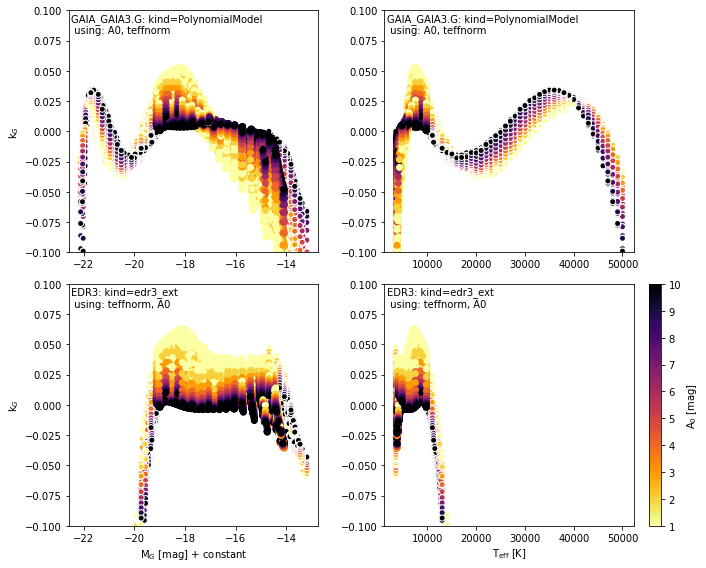

In [2]:
import pandas as pd
from dustapprox import models
from dustapprox.literature import edr3
import pylab as plt

# get Gaia models
lib = models.PrecomputedModel()
# r_ = lib.find(passband='Gaia')[0]  # taking the first one
model = lib.load_model('../gaiadr3_a0_tmp.ecsv', passband='GAIA_GAIA3.G')

# get some data
data = pd.read_csv('../docs/models/precomputed/kurucs_gaiaedr3_small_a0_grid.csv')
df = data[(data['passband'] == 'GAIA_GAIA3.G') & (data['A0'] > 0)]

# values
ydata = (df['mag'] - df['mag0']) / df['A0']
kg_edr3 = edr3.edr3_ext().from_teff('kG', df['teff'], df['A0'])
delta_edr3 = ydata - kg_edr3
delta = ydata - model.predict(df)
# note: edr3 model valid for 3500 < teff < 10_000
selection = '3500 < teff < 10_000'
select = df.eval(selection)

plt.figure(figsize=(10, 8))
cmap = plt.cm.inferno_r

title = "{name:s}: kind={kind:s}\n using: {features}".format(
        name=model.name,
        kind=model.__class__.__name__,
        features=', '.join(model.feature_names))

kwargs_all = dict(rasterized=True, edgecolor='w', cmap=cmap, c=df['A0'])
kwargs_select = dict(rasterized=True, cmap=cmap, c=df['A0'][select])

ax0 = plt.subplot(221)
plt.scatter(df['mag0'], delta, **kwargs_all)
plt.scatter(df['mag0'][select], delta[select], **kwargs_select)
plt.colorbar().set_label(r'A$_0$ [mag]')
plt.ylabel(r'k$_G$')
plt.text(0.01, 0.99, title, fontsize='medium',
        transform=plt.gca().transAxes, va='top', ha='left')

ax1 = plt.subplot(222, sharey=ax0)
plt.scatter(df['teff'], delta, **kwargs_all)
plt.scatter(df['teff'][select], delta[select], **kwargs_select)
plt.colorbar().set_label(r'A$_0$ [mag]')
plt.text(0.01, 0.99, title, fontsize='medium',
        transform=plt.gca().transAxes, va='top', ha='left')

title = "{name:s}: kind={kind:s}\n using: {features}".format(
           name="EDR3",
           kind=edr3.edr3_ext().__class__.__name__,
           features=', '.join(('teffnorm', 'A0')))

ax = plt.subplot(223, sharex=ax0, sharey=ax0)
plt.scatter(df['mag0'], delta_edr3, **kwargs_all)
plt.scatter(df['mag0'][select], delta_edr3[select], **kwargs_select)
plt.colorbar().set_label(r'A$_0$ [mag]')
plt.xlabel(r'M$_G$ [mag] + constant')
plt.ylabel(r'k$_G$')
plt.ylim(-0.1, 0.1)
plt.text(0.01, 0.99, title, fontsize='medium',
        transform=plt.gca().transAxes, va='top', ha='left')


plt.subplot(224, sharex=ax1, sharey=ax1)
plt.scatter(df['teff'], delta_edr3, **kwargs_all)
plt.scatter(df['teff'][select], delta_edr3[select], **kwargs_select)
plt.xlabel(r'T$_{\rm eff}$ [K]')
plt.colorbar().set_label(r'A$_0$ [mag]')
plt.ylim(-0.1, 0.1)

plt.setp(plt.gcf().get_axes()[1:-1:2], visible=False)

plt.text(0.01, 0.99, title, fontsize='medium',
        transform=plt.gca().transAxes, va='top', ha='left')

plt.tight_layout()